### Семинар 
8.05.20

План
1. librosa
2. Mel Spectrogram: STFT (Short Time Fourier Transform), Spectrogram, Mel-basis
3. Naive bio Gender Classifier
4. Improvements



In [0]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm, tqdm_notebook
import joblib as jl
import os

import matplotlib.pyplot as plt
import IPython # прослушивание аудио в ноутбуке
import numpy as np # отсюда возьмем Фурье
import librosa # множественные манипуляции с аудиофайлами 
%matplotlib inline

import torch
from torch.utils.data import DataLoader
plt.style.use('fivethirtyeight')

In [5]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [6]:
!ffmpeg -i sample.mp3 sample.wav

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [7]:
IPython.display.Audio('sample.wav')

### **Часть 1**

Напоминание: файл *.wav -- набор амплитуд, отсчитываемых за определенные промежутки времени. Sample rate (sr) -- число отсчитываемых амплитуд в секунду, параметр качества записи. Построим график амплитуд:

58752 points, 2.6644897959183673 sec, sr 22050


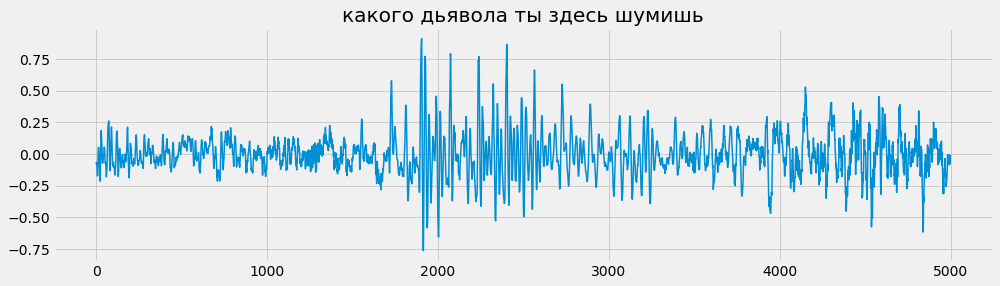

In [8]:
amplitudes, sample_rate = librosa.core.load("sample.wav")

print(f"{len(amplitudes)} points, {len(amplitudes) / sample_rate} sec, sr {sample_rate}")
plt.figure(figsize=[15, 4])
plt.title('какого дьявола ты здесь шумишь')
plt.plot(amplitudes[20000:25000],linewidth=1.5)

In [9]:
type(amplitudes)

numpy.ndarray

В двух секундах 60000 точек! Работать неудобно, надо конвертировать в формат, с которым умеем работать (в изображение). Используем **быстрое преобразование Фурье** чтобы понять, какие же именно компоненты преобладают в некоторый момент времени. Подробнее: https://en.wikipedia.org/wiki/Short-time_Fourier_transform


<img src="https://upload.wikimedia.org/wikipedia/commons/c/c5/Spectrogram-19thC.png" width="640px">


Не забудем, что перед преобразование Фурье мы используем к фреймам по отдельности и потом склеиваем все в единую картину. Также следует помнить, что если использовать просто спектрограмму без перехода в мел-пространство, то мы можем сломать нашу будущую сетку слишком большими значениями. Подробнее: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum


<img src="https://labrosa.ee.columbia.edu/doc/HTKBook21/img165.gif" width="640px">

**Алгоритм построения мел-спектрограммы по набору частот:**
1. Разделяем вход на пересекающиеся фреймы
2. Применяем к каждому преобразование Фурье
3. Переводим полученную спектрограмму в мел-пространство

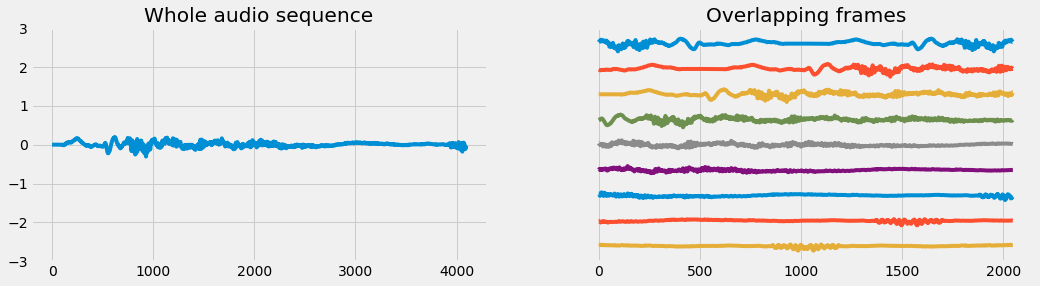

In [10]:
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # output shape: [window_length, num_windows]

dummy_amps = amplitudes[2048: 6144]
dummy_frames = slice_into_frames(dummy_amps, 2048, 512)

plt.figure(figsize=[16, 4])
plt.subplot(121, title='Whole audio sequence', ylim=[-3, 3])
plt.plot(dummy_amps)

plt.subplot(122, title='Overlapping frames', yticks=[])
for i, frame in enumerate(dummy_frames.T):
    plt.plot(frame + 10 - i);

In [0]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # slice amplitudes into overlapping frames [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # get weights for fourier transform, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # apply fourier transfrorm to frames scaled by weights
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

In [0]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes], time-series of sound amplitude, same as above
    :param sample rate: num amplitudes per second
    :param n_mels: spectrogram channels
    :param window_length: length of a patch to which you apply FFT
    :param hop_length: interval between consecutive windows
    :param f_min: minimal frequency
    :param f_max: maximal frequency
    :returns: mel-spetrogram [n_mels, duration]
    """
    # Step I: compute Short-Time Fourier Transform
    stft = get_STFT(amplitudes, window_length,hop_length)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // 512 + 1)
    
    # Step II: convert stft to a spectrogram
    spectrogram = np.abs(stft)
    
    # Step III: convert spectrogram into Mel basis (multiplying by transformation matrix)
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // 512 + 1)
    
    return mel_spectrogram

In [0]:
amplitudes1, _ = librosa.core.load("sample1.wav")
amplitudes2, _ = librosa.core.load("sample2.wav")

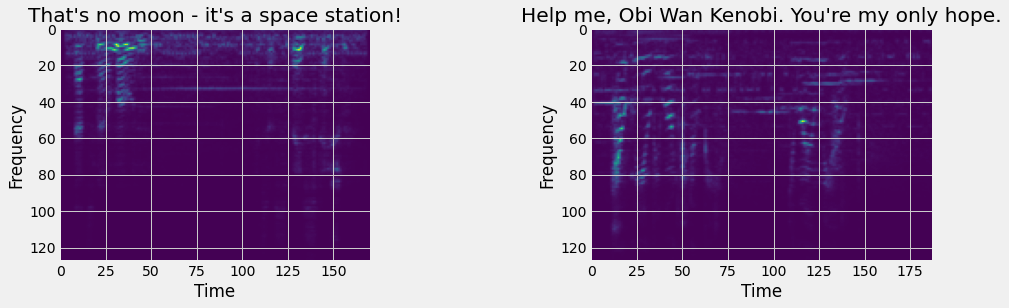

In [14]:
plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("That's no moon - it's a space station!"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes1))

plt.subplot(1, 2, 2)
plt.title("Help me, Obi Wan Kenobi. You're my only hope."); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes2));

In [15]:
IPython.display.Audio('sample1.wav')

In [16]:
IPython.display.Audio('sample2.wav')

## Часть 2
Напишем простой классификатор биологического гендера спикера по мел спектрограмме. 
Сразу вопрос -- откуда возьмем данные?

In [17]:
!wget https://ndownloader.figshare.com/files/10256148

--2020-05-07 00:08:14--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 3.248.161.73, 34.249.140.248, 52.214.52.154, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|3.248.161.73|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip [following]
--2020-05-07 00:08:15--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.53.178
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.53.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440207227 (420M) [binary/octet-stream]
Saving to: ‘10256148’

10256148            100%[===================>] 419.81M  11.5MB/s    in 38s     

2020-05-07 00:08:55 (10.9 MB/s) - ‘10256148’ saved [440207227/440207227]



In [0]:
!unzip -q 10256148

In [19]:
!pip install timit-utils

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=a11a8c7d6da7ca13e7ca941b1e70f31728747aa8dabeaa9c8bf54d9fcbbada5a
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


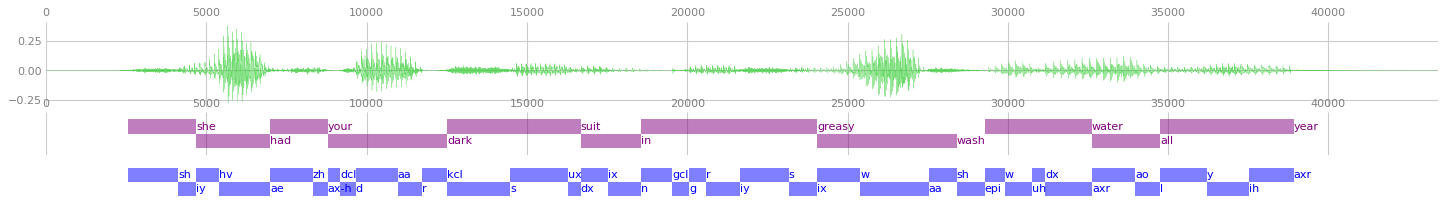

In [20]:
%matplotlib inline
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

DATA_PATH = 'data/lisa/data/timit/raw/TIMIT'
corpus = tu.Corpus(DATA_PATH)
sentence = corpus.train.sentences_by_phone_df('aa').sentence[0]
du.DrawVerticalPanels([du.AudioPanel(sentence.raw_audio, show_x_axis=True),
                       du.WordsPanel(sentence.words_df, sentence.raw_audio.shape[0], show_x_axis=True),
                       du.PhonesPanel(sentence.phones_df, sentence.raw_audio.shape[0])
                      ])
  

In [0]:
class Speaker:

  def __init__(self, data_path):
    self.doc_file_path = os.path.join(data_path, 'DOC','SPKRINFO.TXT')
    with open(self.doc_file_path) as f:
      self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])

  def return_sex(self, id):
    return self.id_sex_dict[id]

Speakers_info = Speaker(DATA_PATH)

In [0]:
person_1 = corpus.test.person_by_index(150)

In [57]:
person_1.name

'WSH0'

In [59]:
Speakers_info.return_sex(person_1.name)

'M'

In [64]:
person_1.sentences[0]

KeyError: ignored

In [61]:
IPython.display.Audio(person_1.sentence_by_index(1).raw_audio, rate=16000)

In [139]:
def preprocess_sample(amplitudes, gender, sr=16000, max_length=128):
    spectrogram = get_melspectrogram(amplitudes, sample_rate=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='reflect')
    target = 1 if gender == 'F' else 2
    return np.float32(spectrogram), np.int64(target)
    
preprocess_sample(person_1.sentence_by_index(0).raw_audio, Speakers_info.return_sex(person_1.name))

(array([[5.44851704e-04, 4.57755261e-04, 6.38172787e-04, ...,
         4.00972640e-04, 3.88277054e-04, 1.49328064e-03],
        [3.88431043e-04, 3.85604159e-04, 5.40036475e-04, ...,
         3.67009401e-04, 3.70297028e-04, 4.69909282e-04],
        [3.60231468e-04, 3.92367103e-04, 3.42930463e-04, ...,
         8.30345612e-04, 4.09984641e-04, 7.83285708e-04],
        ...,
        [1.62985831e-04, 1.49375905e-04, 1.11242334e-04, ...,
         1.73215041e-04, 3.17189988e-04, 3.54899268e-04],
        [2.07262550e-04, 1.68814528e-04, 1.31155495e-04, ...,
         2.37886896e-04, 5.22523595e-04, 5.41565765e-04],
        [9.26658613e-05, 8.05743839e-05, 6.87235442e-05, ...,
         1.92747990e-04, 3.21458909e-04, 2.49324890e-04]], dtype=float32), 2)

Создадим тестсет и трейнсет из данных для `TIMIT` 

In [0]:
def create_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(person.sentence_by_index(i).raw_audio, target))
  return spectrograms_and_targets

In [235]:
trainset = create_dataset('train')
validset = create_dataset('test')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
trainloader = DataLoader(trainset, batch_size=4, shuffle=42)
validloader = DataLoader(validset, batch_size=4, shuffle=42)

In [0]:
class Net(nn.Module):
  <IDEAS?>

net = Net()

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [0]:
<LET`S GO?>

Простые идеи для улучшения классификатора:
1. 1d or 2d convolutions + batchnorm
2. VGG-like, residual
3. Upper batch size
4. Data augmentation (background noise? jitter? freq?)
5. Denoising?